In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Preparing the Data

In [ ]:
def find_files(path):
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

# Read a file and split into lines
def read_lines(fname):
    lines = open(fname, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

In [ ]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
for fname in find_files('/content/drive/MyDrive/Colab Notebooks/ICE3050/dataset/names/*.txt'):
    category = os.path.splitext(os.path.basename(fname))[0]
    all_categories.append(category) # country name
    lines = read_lines(fname)
    category_lines[category] = lines

n_categories = len(all_categories)

In [ ]:
print(all_categories[:5])
print(category_lines['Korean'][:5])

['Polish', 'Irish', 'Greek', 'French', 'Korean']
['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']


In [ ]:
all_categories

['Polish',
 'Irish',
 'Greek',
 'French',
 'Korean',
 'Vietnamese',
 'German',
 'Portuguese',
 'Spanish',
 'Japanese',
 'Russian',
 'English',
 'Dutch',
 'Chinese',
 'Arabic',
 'Czech',
 'Italian',
 'Scottish']

# 2. Turning Names into Tensors

* To represent a single letter, we use a "one-hot vector" of size ```<1 x n_letters>```. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. ```"b" = <0 1 0 0 ...>```.

* To make a word we join a bunch of those into 2D matrix ```<line_length x 1 x n_letters>```.

* That extra 1 dimension is because PyTorch assumes everything is in batches - we're just using a batch size of 1 here.

In [ ]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

In [ ]:
print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [ ]:
kim_encoded = line_to_tensor('Kim')
print(kim_encoded.size())
print(kim_encoded)

torch.Size([3, 1, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])


# 3. Creating the Network

![link text](https://i.imgur.com/Z2xbySO.png)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) #input to hidden
        self.i2o = nn.Linear(input_size + hidden_size, output_size) #input to output
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

* To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initializes as zeros at first).

In [ ]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input_letter = letter_to_tensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_letter, hidden)

In [ ]:
print(all_categories)
print(output)

['Polish', 'Irish', 'Greek', 'French', 'Korean', 'Vietnamese', 'German', 'Portuguese', 'Spanish', 'Japanese', 'Russian', 'English', 'Dutch', 'Chinese', 'Arabic', 'Czech', 'Italian', 'Scottish']
tensor([[-2.9885, -2.9676, -2.8137, -2.9350, -2.9450, -2.9256, -2.8025, -2.7950,
         -2.8481, -2.9722, -2.8606, -2.9243, -2.8716, -2.8580, -2.9523, -2.8863,
         -2.9119, -2.8029]], grad_fn=<LogSoftmaxBackward0>)


* For the sake of efficiency we don't want to create a new Tensor for every step, so we will use ```line_to_tensor``` instead of ```letter_to_tensor``` and use slices.

In [ ]:
input_line = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden) #first layer의 hidden state는 zero 로 initialize

output, next_hidden = rnn(input_line[0], hidden)
print(output)

tensor([[-2.9885, -2.9676, -2.8137, -2.9350, -2.9450, -2.9256, -2.8025, -2.7950,
         -2.8481, -2.9722, -2.8606, -2.9243, -2.8716, -2.8580, -2.9523, -2.8863,
         -2.9119, -2.8029]], grad_fn=<LogSoftmaxBackward0>)


# 4. Training

### 4.1. Preparing for Training

In [ ]:
def category_from_output(all_categories, output):
    # https://pytorch.org/docs/stable/generated/torch.topk.html
    top_n, top_i = output.topk(1)
    category_idx = top_i[0].item()
    return all_categories[category_idx], category_idx

def random_choice(lst):
    return lst[random.randint(0, len(lst)-1)]

def random_sample(all_categories, category_lines):
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor(
        [all_categories.index(category)], dtype=torch.long
    )
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [ ]:
print(category_from_output(all_categories, output))

for i in range(5):
    category, line, category_tensor, line_tensor = random_sample(all_categories, category_lines)
    print('category:', category, '/ line:', line)

('Portuguese', 7)
category: Arabic / line: Toma
category: Vietnamese / line: Duong
category: Arabic / line: Hadad
category: German / line: Dietrich
category: English / line: Prescott


### 4.2. Training the Network

* Each loop of training will:

    1. Create input and target tensors
    2. Create a zeroed initial hidden state
    3. Read each letter in and keep hidden state for next letter
    4. Compare final output to target
    5. Back-propagate
    6. Return the output and loss

In [ ]:
def train(rnn, all_categories, category_lines, epochs, lr, log_every):
    # set seed
    torch.manual_seed(444)

    # loss
    loss_fn = nn.NLLLoss()

    # step function
    def one_step(category_tensor, line_tensor):
        # intialize hidden state
        hidden = rnn.init_hidden()
        # set all gradients zero
        rnn.zero_grad()
        # loop through all letters in a line
        for one_hot_letter in line_tensor:
            output, hidden = rnn(one_hot_letter, hidden)
        # compute loss
        loss = loss_fn(output, category_tensor)
        # backward propagation
        loss.backward()
        # update parameters 
        for p in rnn.parameters(): #optimizer 써도됨ㅁ
            p.data.add_(p.grad.data, alpha=-lr)
        return output, loss.item()
    
    current_loss, losses = 0, []
    for e in range(1, epochs+1):
        category, line, category_tensor, line_tensor = random_sample(all_categories, category_lines)
        output, loss = one_step(category_tensor, line_tensor)
        current_loss += loss
        if e % log_every == 0:
            # get category from output and see if correct
            guess, _ = category_from_output(all_categories, output)
            log = f'Epochs: {e}/{epochs}, Loss: {loss:.4f}, ' \
                  f'IN: {line}, OUT (GT): {guess} ({category})'
            print(log)
            # add current loss avg to list of losses
            losses.append(current_loss / log_every)
            current_loss = 0
    
    return losses

In [ ]:
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
losses = train(rnn, all_categories, category_lines, epochs=100000, lr=0.005, log_every=5000)

Epochs: 5000/100000, Loss: 2.7145, IN: Faucheux, OUT (GT): Polish (French)
Epochs: 10000/100000, Loss: 2.5993, IN: Makukha, OUT (GT): Japanese (Russian)
Epochs: 15000/100000, Loss: 2.2992, IN: Mikhailyants, OUT (GT): Greek (Russian)
Epochs: 20000/100000, Loss: 2.9261, IN: Toma, OUT (GT): Japanese (Arabic)
Epochs: 25000/100000, Loss: 1.1332, IN: Nghiem, OUT (GT): Vietnamese (Vietnamese)
Epochs: 30000/100000, Loss: 1.8440, IN: Renaud, OUT (GT): Arabic (French)
Epochs: 35000/100000, Loss: 0.4906, IN: Bellomi, OUT (GT): Italian (Italian)
Epochs: 40000/100000, Loss: 1.1532, IN: Naito, OUT (GT): Japanese (Japanese)
Epochs: 45000/100000, Loss: 3.5111, IN: Samuel, OUT (GT): Arabic (Irish)
Epochs: 50000/100000, Loss: 2.0886, IN: Sokal, OUT (GT): Arabic (Polish)
Epochs: 55000/100000, Loss: 0.3072, IN: Poniros, OUT (GT): Greek (Greek)
Epochs: 60000/100000, Loss: 1.0567, IN: Gomolka, OUT (GT): Polish (Polish)
Epochs: 65000/100000, Loss: 1.3739, IN: Ma, OUT (GT): Korean (Vietnamese)
Epochs: 70000/1

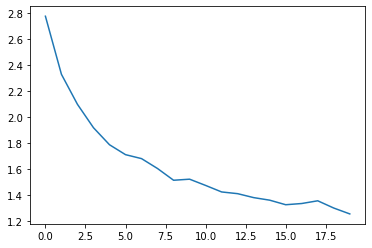

In [ ]:
plt.plot(losses)

In [ ]:
# unmount drive
drive.flush_and_unmount()

# 5. Optional readings

* [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)